In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from modules.models import create_dense_model, KleinGordonEquation
from modules.data import simulate_klein_gordon
from modules.plots import plot_training_loss, plot_pointwise_error_mesh
from modules.utils import PrintLossCallback

2023-03-17 00:44:49.203585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 00:44:49.310501: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 00:44:49.891224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nimahsn-wsl/anaconda3/lib/:/home/nimahsn-wsl/anaconda3/lib/:/home/nimahsn-wsl/anaconda3/env

In [2]:
def f_u_exact(tx):
    """Exact solution of the Klein-Gordon equation."""
    return tx[:, 1:2] * tf.cos(5 * np.pi * tx[:, 0:1]) + (tx[:, 0:1] * tx[:, 1:2]) ** 3

def rhs(tx_colloc):
    """Right-hand side of the Klein-Gordon equation using automatic differentiation."""
    with tf.GradientTape(watch_accessed_variables=False) as tape2:
        tape2.watch(tx_colloc)
        
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(tx_colloc)
            u_colloc = f_u_exact(tx_colloc)
        first_order = tape.batch_jacobian(u_colloc, tx_colloc)
    second_order = tape2.batch_jacobian(first_order, tx_colloc)
    u_tt = second_order[..., 0, 0]
    u_xx = second_order[..., 1, 1]
    return u_tt + -1.0 * u_xx + 1.0 * (u_colloc ** 3)

def rhs_manual(tx):
    """Right-hand side of the Klein-Gordon equation."""
    u = f_u_exact(tx)
    u_tt = -25 * np.pi ** 2 * tx[:, 1:2] * tf.cos(5 * np.pi * tx[:, 0:1]) + 6 * tx[:, 1:2] ** 3 * tx[:, 0:1]
    u_xx = 6 * tx[:, 0:1] ** 3 * tx[:, 1:2]
    return u_tt + -1 * u_xx + 1 * (u ** 3)

In [3]:
t = tf.linspace(0.0, 1.0, 100)
x = tf.linspace(0.0, 1.0, 100)
T, X = tf.meshgrid(t, x)
tx = tf.stack([tf.reshape(T, [-1]), tf.reshape(X, [-1])], axis=1)
u = f_u_exact(tx)
U = tf.reshape(u, tf.shape(T))

2023-03-17 00:44:51.164919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 00:44:51.170153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 00:44:51.170190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 00:44:51.170811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

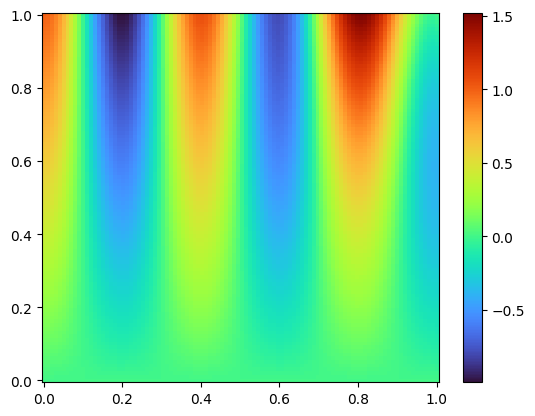

In [4]:
plt.pcolormesh(T, X, U, cmap='turbo', shading='auto')
plt.colorbar()

In [14]:
(tx_colloc, y_res), (tx_init, u_init, ut_init), (tx_bnd, u_bnd) = simulate_klein_gordon(
    n_colloc=600, n_init=200, n_bnd=200, rhs_function=rhs_manual, init_function=f_u_exact, \
        bnd_function=f_u_exact)
inputs = [tx_colloc, tx_init, tx_bnd]
outputs = [f_u_exact(tx_colloc), y_res, u_init, ut_init, u_bnd]

In [15]:
ds_tx_colloc = tf.data.Dataset.from_tensor_slices(tx_colloc)
ds_u_colloc = tf.data.Dataset.from_tensor_slices(f_u_exact(tx_colloc))
ds_y_residuals = tf.data.Dataset.from_tensor_slices(y_res)
ds_tx_init = tf.data.Dataset.from_tensor_slices(tx_init).repeat(3)
ds_u_init = tf.data.Dataset.from_tensor_slices(u_init).repeat(3)
ds_ut_init = tf.data.Dataset.from_tensor_slices(ut_init).repeat(3)
ds_tx_bnd = tf.data.Dataset.from_tensor_slices(tx_bnd).repeat(3)
ds_u_bnd = tf.data.Dataset.from_tensor_slices(u_bnd).repeat(3)
ds_inputs = tf.data.Dataset.zip((ds_tx_colloc, ds_tx_init, ds_tx_bnd))
ds_outputs = tf.data.Dataset.zip((ds_u_colloc, ds_y_residuals, ds_u_init, \
                                ds_ut_init, ds_u_bnd))
dataset = tf.data.Dataset.zip((ds_inputs, ds_outputs)).batch(200)

In [16]:
backbone = create_dense_model([1000, 1000], n_inputs=2, n_outputs=1, activation='tanh', initializer='glorot_normal')
model = KleinGordonEquation(backbone)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.975)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
model.compile(optimizer=optimizer)
cb = [PrintLossCallback(2000-1)]
history = model.fit(dataset, epochs=30000, verbose=0, callbacks=cb)

Epoch: 000000, Lr: 10891.15332, Li: 0.57713, Lb: 1.39679, MAE: 0.84264
Epoch: 001999, Lr: 2.33519, Li: 0.03403, Lb: 0.00626, MAE: 0.04205
Epoch: 003998, Lr: 4.35848, Li: 0.02655, Lb: 0.00553, MAE: 0.06284
Epoch: 005997, Lr: 0.18654, Li: 0.00482, Lb: 0.00155, MAE: 0.03851
Epoch: 007996, Lr: 0.79679, Li: 0.01337, Lb: 0.00329, MAE: 0.03587
Epoch: 009995, Lr: 0.04949, Li: 0.00238, Lb: 0.00052, MAE: 0.02832
Epoch: 011994, Lr: 0.06329, Li: 0.00193, Lb: 0.00038, MAE: 0.02217
Epoch: 013993, Lr: 0.03918, Li: 0.00166, Lb: 0.00020, MAE: 0.02190
Epoch: 015992, Lr: 0.02550, Li: 0.00108, Lb: 0.00016, MAE: 0.01496
Epoch: 017991, Lr: 0.01875, Li: 0.00081, Lb: 0.00012, MAE: 0.01204
Epoch: 019990, Lr: 0.01502, Li: 0.00068, Lb: 0.00008, MAE: 0.01059
Epoch: 021989, Lr: 0.01343, Li: 0.00058, Lb: 0.00006, MAE: 0.00863
Epoch: 023988, Lr: 0.01820, Li: 0.00052, Lb: 0.00004, MAE: 0.00784
Epoch: 025987, Lr: 0.01116, Li: 0.00040, Lb: 0.00002, MAE: 0.00635
Epoch: 027986, Lr: 0.01012, Li: 0.00035, Lb: 0.00002, MAE:

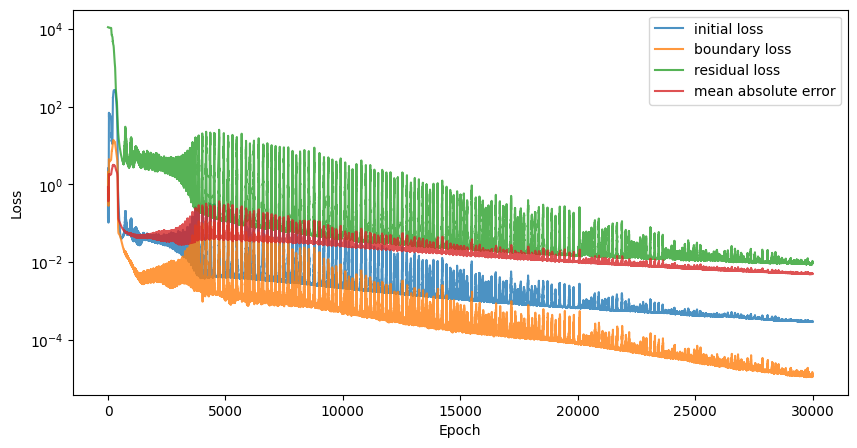

In [17]:
plot_training_loss(history.history, y_scale='log')

In [18]:
u_test = backbone.predict(tx)

313/313 [==============================] - 1s 1ms/step


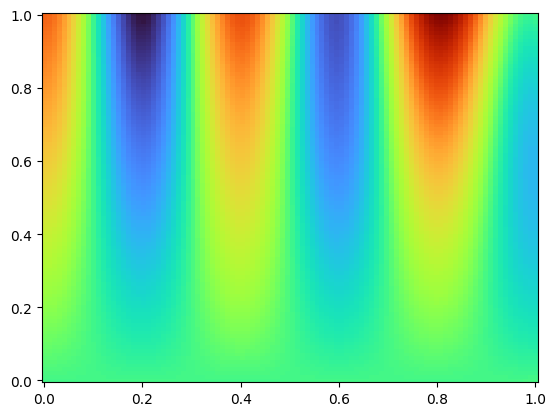

In [19]:
plt.pcolormesh(T, X, tf.reshape(u_test, tf.shape(T)), cmap='turbo', shading='auto')

313/313 [==============================] - 0s 2ms/step


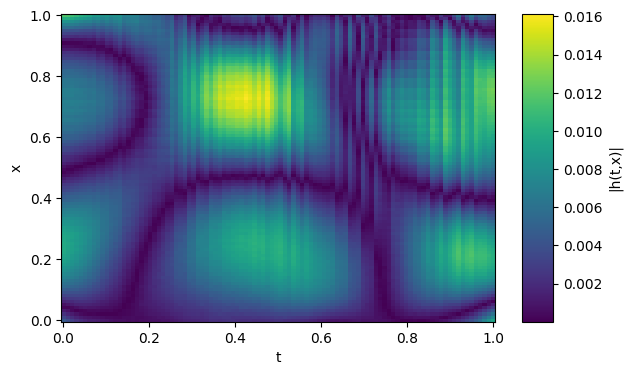

In [20]:
u_test = backbone.predict(tx)
plot_pointwise_error_mesh(u, u_test, T, X)